# H<sub>2</sub> Excitation

This notebook is a Python adaptation of the molecular hydrogen (H<sub>2</sub>) excitation model presented in Togi & Smith (2016, hereafter TS16). We use H<sub>2</sub> line fluxes for the galaxy NGC 5033 as an example of this code's ability to reproduce the power-law slopes and cutoff temperatures given in TS16, as well as the inferred H<sub>2</sub> mass.

We also give blank cells in which to define new line fluxes and run the model for your own object. Note that in this version, **fluxes must be in cgs units for accurate calculations.**

1. [Imports and defining constants](#Imports)
2. [Defining functions](#Functions)
3. [Example use](#Example)
    1. [NGC 5033](#NGC5033)
    2. [Your own example](#BlankExample)


##  Imports and defining constants <a name="Imports"></a>

This notebook uses the following packages:

* **numpy** and **scipy** for handling array functions, including fitting
* **astropy** for unit manipulation
* **operator** for unpacking data for a particular H<sub>2</sub> transition
* **matplotlib** and **IPython** for data visualization 

If you do not have these packages installed, you can install them using pip or conda.

In [1]:
## Data manipulation and fitting
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import astropy.constants as const
from operator import itemgetter


## Visualization
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import display, Math

Lists and dictionaries of relevant constants and variables for the TS16 model.

Values for E, lambda, Einstein A, and degeneracy g are given in order of increasing J_lower. Values for a specific
transition can be accessed by calling `x[j_low]` (e.g., for the J = 4 > 2 or S(2) transition, use `Ek[2]`, `g[2]`, etc.)

The difference between the degeneracy arrays `g` and `g_lib` (and corresponding array of energy levels) is that `g_lib` is only used to compute the partition function of H<sub>2</sub> at a given temperature T.

In [2]:
## Energy levels E_j / k (units Kelvin)
j_lower = np.arange(0,9,1)
j_upper = j_lower + 2
Ek = np.array( [510, 1015, 1681, 2503, 3473, 4585, 5828, 7196, 8677] )


## Corresponding wavelengths (microns) and Einstein A values (s^-1)
lam = np.array( [28.219, 17.035, 12.279, 9.665, 8.025, 6.91, 6.109, 5.511, 5.053] )
coeff_a = 1e-11 * np.array( [2.95, 47.6, 275., 980., 2640., 5880., 11400., 20000., 32400.] )

     
## Degeneracy values for para and ortho H<sub>2</sub>
g = np.zeros(len(j_lower)) ## Access para H<sub>2</sub> with g[::2] (even j) and ortho H<sub>2</sub> with g[1::2] (odd j)

for j in j_upper:
    if j%2 == 0:
        g[j-2] += 2*j+1
    else:
        g[j-2] += 3*(2*j+1)
        
        
## A dictionary containing the above arrays. For easier access and indexing when some lines are absent
## (e.g., when S(0) isn't available, which may otherwise throw off the choice of normalization index j_norm)
linedict = dict()

for j in j_lower:
    tempdict = {"gu":g[j], "lam":lam[j], "A":coeff_a[j], "Eu":Ek[j]}
    
    linedict["S"+str(j)] = tempdict       


## Energy levels E_j / k (units Kelvin)
## Used only to accurately compute partition functions.
j_lower_lib = np.arange(0,15,1)
j_upper_lib = j_lower_lib + 2
Ek_lib = np.array( [510, 1015, 1681, 2503, 3473, 4585, 5828, 7196, 8677, 10263, 11940, 13703, 15549, 17458, 19402] )

g_lib = np.zeros(len(j_lower_lib)) ## Access para H<sub>2</sub> with g[::2] (even j) and ortho H<sub>2</sub> with g[1::2] (odd j)

for j in j_upper_lib:
    if j%2 == 0:
        g_lib[j-2] += 2*j+1
    else:
        g_lib[j-2] += 3*(2*j+1)
        
        
## Constant upper temperature limit Tu = 2000 K
Tu = 2000

## Defining functions <a name="Functions"></a>

In this section we define the functions necessary to evaluate the TS16 model. Details on the purpose, inputs, and outputs of each are given in block comments above the function definition.

In [3]:
"""
Evaluate the partition function Z(T). To be used when calculating column density ratios.

Input: Temperature t

Output: Sum of the partition functions z_p and z_o (for para- and ortho-H<sub>2</sub>). Includes a term for the ground
states of para-H<sub>2</sub> (J = 0 or g = 0) and ortho-H<sub>2</sub> (J = 1 or g = 9).
"""

def evaluate_z(t):
    ## Partition function for para H<sub>2</sub>, even J_upper
    z_p = 1 + np.sum([g_lib[j] * np.exp(-1 * Ek_lib[j]/t) for j in j_lower_lib[::2]])

    ## Partition function for ortho H<sub>2</sub>, odd J_upper
    z_o = (9 * np.exp(-170./t))  + np.sum([g_lib[j] * np.exp(-1 * Ek_lib[j]/t) for j in j_lower_lib[1::2]])
    
    return z_p+z_o

###################################

"""
The empirical column density ratio from flux ratios, normalized to the S(1) transition (J = 3 > 1)
(see Equation 11 from TS16).

Input: 
- Array of measured line fluxes flux. Assumed to be given in order of increasing J.
- Integer j_norm, indicating the J_final of the state to which all fluxes are normalized; defaults to 
j_norm = 1 for the S(1) (J = 3 -> 1) transition.
- Array of integers j_obs representing transition final states. E.g., if only the S(1), S(2), and S(3) transitions
have measurements, j_obs is the array [1, 2, 3].

Output: Dictionary of column density ratios relative to a chosen transition.
"""

def nratio_flux(flux, j_norm, j_obs):
    print("Calculating empirical column density ratios for the following transitions:",str(j_obs))
    
    ## Initialize an empty dictionary for the column density ratios
    fratios = dict()
    
    ## Retrieve parameters relevant to transition j_norm
    g_norm, lam_norm, A_norm, Eu_norm = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j_norm)])

    for j in j_lower:
        if j not in j_obs:
            pass
        else:
            idx = np.where(j_obs == j)[0][0]
            idx_norm = np.where(j_obs == j_norm)[0][0]
            
            ## Retrieve parameters relevant to transition j
            g, lam, A, Eu = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j)])

            ## Compute empirical column density ratios using TS16 eq. 11
            fr = (g_norm / g) * ((flux[idx] * lam) / A) / ((flux[idx_norm] * lam_norm) / A_norm)
            fratios["S"+str(j)] = fr

    return np.array(list(fratios.values())), np.array(list(fratios.keys()))

###################################

"""
The fractional uncertainties on the flux ratios, normalized to the S(1) transition (J = 3 > 1)
(see Equation 11 from TS16).

Input: 
- Array of measured line fluxes flux and flux uncertainties err. Assumed to be given in order of increasing J.
- Integer j_norm, indicating the J_final of the state to which all fluxes are normalized; defaults to 
j_norm = 1 for the S(1) (J = 3 -> 1) transition.
- Array of integers j_obs representing transition final states. E.g., if only the S(1), S(2), and S(3) transitions
have measurements, j_obs is the array [1, 2, 3].

Output: Array of fractional flux uncertainties normalized to a chosen transition.
Translate this into uncertainties on the column density ratios by multiplying this array by your nominal 
value array from the function nratio_flux().

"""

def flux_un(flux, err, j_norm, j_obs):
    ## Initialize an empty dictionary for the flux uncertainties
    unc = dict()
    
    ## Retrieve parameters relevant to transition j_norm
    g_norm, lam_norm, A_norm, Eu_norm = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j_norm)])

    for j in j_lower:
        if j not in j_obs:
            pass
        else:
            idx = np.where(j_obs == j)[0][0]
            idx_norm = np.where(j_obs == j_norm)[0][0]
            
            ## Retrieve parameters relevant to transition j
            g, lam, A, Eu = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j)])

            ## Compute fractional flux uncertainty of transition j, normalized to j_norm
            ## Note that these are FLUX uncertainties, not column-density uncertainties
            unratio = ( (err[idx]/flux[idx])**2 + (err[idx_norm]/flux[idx_norm])**2 )**0.5
            unc["S"+str(j)] = unratio

    return np.array(list(unc.values())), np.array(list(unc.keys()))

###################################

"""
The theoretical column density ratio for transition j from the TS16 continuous temperature model
(see their Equation 12). To generate predicted ratios for a set of observed transitions, 
iterate over the appropriate array of J_low values.

Input:
- Integers j and j_norm, respectively indicating the J_final of the transition being modeled and the J_final of
the state to which all fluxes are normalized; defaults to j_norm = 1 for the S(1) (J = 3 -> 1) transition.
- Power law slope n.
- Temperature integral bounds Tu and Tl. 

Output: Predicted column density of transition j+2 relative to N_3 (the S(1) transition)
"""

j_norm = 1
def nratio_model(j_obs, n, Tl):
    ## Initialize an empty dictionary for the column density ratios
    modelratios = dict()
    
    ## Retrieve parameters relevant to transition j_norm
    g_norm, lam_norm, A_norm, Eu_norm = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j_norm)])
    
    for j in j_lower:
        if j not in j_obs:
            pass
            
        else:
            ## Retrieve parameters relevant to transition j
            g, lam, A, Eu = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j)])
            
            ## Evaluate the numerator and denominator of TS16 equation 12
            numer = integrate.quad(lambda t: (1 / evaluate_z(t)) * np.exp( -1 * Eu / t ) * t**(-n), Tl, Tu)
            denom = integrate.quad(lambda t: (1 / evaluate_z(t)) * np.exp( -1 * Eu_norm / t ) * t**(-n), Tl, Tu)
            modelratios["S"+str(j)] = numer[0]/denom[0]
            
    return np.array(list(modelratios.values()))

###################################

"""
The inferred total column density of warm H2 (see Equation 9 from TS16)

Input:
- Line flux "flux" for transition "j_" that is used for the mass computation. In principle this could be any 
transition, though we recommend using S(0), S(1), or S(2).
- Power law slope n.
- Temperature integral bounds Tu and Tl.

Output: Array of the "total" column density of warm H<sub>2</sub>, as calculated from each modeled line flux. User can then
choose a single value as the fiducial measurement, take a median/average of the whole array, etc.
"""

def n_total(flux, j_, j_obs, om, n, Tl):
    
    if j_ not in j_obs:
        raise Exception("Transition "+str(j_)+" not in list.")
    else:
        idx = np.where(j_obs == j_)[0][0]

        ## Retrieve parameters relevant to transition j
        g, lam, A, Eu = itemgetter('gu', 'lam', 'A', 'Eu')(linedict["S"+str(j_)])

        ## Evaluate the definite integral in TS16 Equation 3
        n_integral = integrate.quad(lambda t: (g / evaluate_z(t)) * np.exp( -1 * Eu / t ) * t**(-n), Tl, Tu)[0]

        ## Plug and chug values in TS16 Equation 9
        column = (4 * np.pi * flux[idx] * lam * (Tl**(1-n) - Tu**(1-n))) / \
        (A * const.h.to("erg s").value * const.c.to("micron/s").value * om.value * (n - 1) * n_integral)

        return column

## Example use <a name="Example"></a>

### NGC 5033 <a name="NGC5033"></a>

The next several cells illustrate how to use the TS16 model to compute the power-law slope, cutoff temperature
T<sub>l</sub>, and H<sub>2</sub> mass using real H<sub>2</sub> line measurements for the galaxy NGC 5033 (see TS16 Table 2 and references therein). 

* Enter the measured fluxes and flux uncertainties, as well as the transitions J that they correspond to.
* Initial value for the beam size `omega`. This can be arbitrary (if all you're interested in is the H<sub>2</sub> mass) or the actual beam size of your observations (if you want N(H<sub>2</sub>)).
* Call on the functions `nratio_flux()` and `flux_un()` to convert to column densities.
* Pass the arrays `nratio` and `nratio_err` to `scipy.curve_fit()` to obtain best-fit values for n and T<sub>l</sub> and their corresponding uncertainties.

In [4]:
f = 1e-14*np.array( [3.66, 18.20, 06.35, 12.69] ) ## Line fluxes for NGC 5033, in erg/s
ferr = 1e-14 * np.array( [0.35, 1.04, 0.31,1.91] ) ## Line fluxes for NGC 5033, in erg/s

jobs = np.array( [0, 1, 2, 3]) ## Lower J of transitions observed for NGC 5033
j_norm = 1
omega = (15*u.arcsec**2).to('sr') ## Arbitrary beam size in sq. arcsec
D = 14.8 * u.Mpc ## Distance in Mpc


## Compute the empirical column density ratios and their fractional uncertainty
nratio, nratio_j = nratio_flux(f, 1, jobs)
flux_err, flux_err_j = flux_un(f, ferr, 1, jobs)
nratio_err = nratio * flux_err

Calculating empirical column density ratios for the following transitions: [0 1 2 3]


The values of the `bounds` parameter in `scipy.curve_fit()` can be tweaked as necessary to prevent runaway values. By default they are set such that (3 < n < 7) and (30 K < T<sub>l</sub> < 500 K).

Note that the best-fit values of n and T<sub>l</sub> for NGC 5033 inferred by this Python version of the TS16 model are slightly different (but consistent within uncertainties) with those reported in TS16 itself (their Table 4), using the original IDL version. This may be because of differences in the curve fitting algorithm, but as we show later, the new (n, T<sub>l</sub>) values produce a fit that is qualitatively just as good.



The best-fit values found by `scipy.curve_fit()` can then be used to compute either the total** **column density** of H<sub>2</sub> following TS16 eq. 9, or the total H<sub>2</sub> **mass** following TS16 eqs. 13 and 14.
\** Note that this is the total mass between your temperature bounds T<sub>l</sub> and a constant T<sub>u</sub> = 2000 K. Change the value of T<sub>l</sub> to T' to examine the mass encompassed by other temperature bounds.

In [5]:
params, cov = curve_fit(nratio_model, jobs, nratio, sigma=nratio_err, bounds = ([3., 20.], [7., 300.]))

print("Best fit values (n, Tl):",params, "and their uncertainties:",np.sqrt(np.diag(cov)))

best_slope, best_T = params[0], params[1] ## Assign the best-fit values to variables for later use
best_model_nratio = nratio_model(jobs, best_slope, best_T) ## Create a set of predicted column density ratios from the best model

Best fit values (n, Tl): [ 4.75510364 71.21086702] and their uncertainties: [ 0.1199524  15.38466278]


In [6]:
## Use the best-fit values above to compute the total column density and/or mass
total_column = n_total(f, 1, jobs, omega, best_slope, best_T) ## The total column density in cm^-2
total_number = total_column * omega.value * (D.to("cm").value)**2 ## The total number density given distance D and beam size omega

mh2 = total_number * (3.32e-27 / const.M_sun.value) # number density * hydrogen mass in Msun units
print("The total mass of H2 between",round(best_T,1), "and 2000 K is", round(mh2, 1), "Msun")

The total mass of H2 between 71.2 and 2000 K is 62746512.8 Msun


To compute an uncertainty on the H<sub>2</sub> mass, repeat the above calculations using the diagonals from the `cov` variable that is output by `scipy.curve_fit()`.

I **think** the correct way to do get an upper uncertainty on the mass is to use the +1$\sigma$ value of `n` and the -1$\sigma$ value of `T`, which will maximize the area under the power-law curve. And vice-versa for the lower bound on the mass.

In [7]:
## Define the +/- 1sigma values for n and T
upp_slope, upp_T = best_slope+np.sqrt(np.diag(cov))[0], best_T+np.sqrt(np.diag(cov))[1]
low_slope, low_T = best_slope-np.sqrt(np.diag(cov))[0], best_T-np.sqrt(np.diag(cov))[1]

## Create an empty array in which to store the H2 mass uncertainties
mh2_unc = np.array([0.,0.])
i=0

## Compute the column and number densities as before, iterating over the new pairs of (n, T).
## These values are s
for (n, T) in zip([low_slope, upp_slope], [upp_T, low_T]):
    column = n_total(f, 1, jobs, omega, n, T)
    number = column * omega.value * (D.to("cm").value)**2
    mh2_unc[i] += number * (3.32e-27 / const.M_sun.value) # number * hydrogen mass in Msun units
    
    i+=1

    
## Use np.diff() and IPython Math text formatting to print the mass estimate and uncertainties in a friendly way
mass_array = np.array( [mh2_unc[0], mh2, mh2_unc[1]] )
q = np.diff(mass_array)

## Feel free to change the 1e7 factor to suit your desired units/scaling
txt = r"M_{{H2}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}~~(\times~ 10^7 M_{{\odot}})"
txt = txt.format(mass_array[1] / 1e7, q[0] / 1e7, q[1] / 1e7)
display(Math(txt))

<IPython.core.display.Math object>

Let's visualize how well the best-fit model follows the empirical column density ratios using `matplotlib`. I'm using log scaling on the x axis to more easily spot deviations from the model, but this can be set to `linear` to use a more standard visualization. I'm also not plotting error bars, because the uncertainties are smaller than the symbols for each data point.

The best-fit model that this Python code infers, (n, T<sub>l</sub>) = (4.77, 71), are slightly different than what is reported for the same galaxy in TS16, (n, T<sub>l</sub>) = (4.65, 51). To see the difference in the quality of the fits, let's plot both model predictions.

We can see that although the model parameters are slightly different (especially the cutoff temperature T<sub>l</sub>), qualitatively they both do a good job at describing the observed H<sub>2</sub> column density ratios.

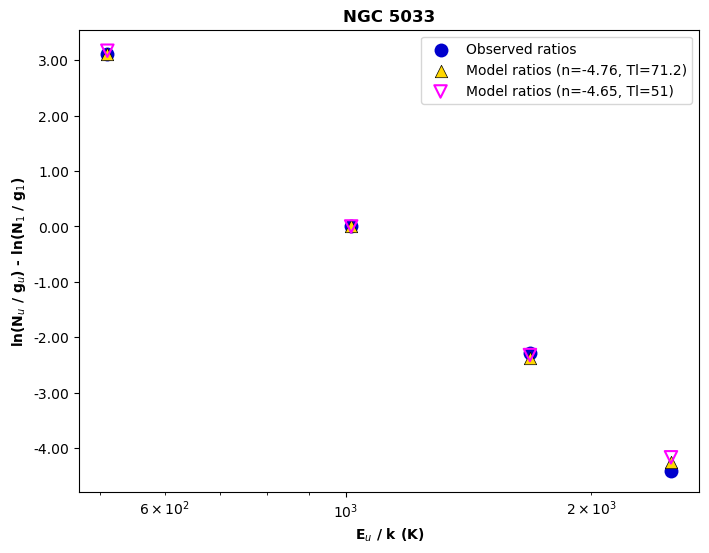

In [8]:
fig, ax = plt.subplots(figsize=(8,6))


## Plot the empirical column density ratios
ax.scatter(Ek[jobs], np.log(nratio),
            marker='o', color = 'mediumblue', s=100, lw=0, label = "Observed ratios")

## Plot the predicted column density ratios using the best-fit model
ax.scatter(Ek[jobs], np.log(best_model_nratio), color='gold', edgecolor='black', lw=0.5, marker='^', 
           s=80, label = "Model ratios (n=-"+str(round(best_slope,2)) + ", Tl=" + str(round(best_T,1)) + ")")


ts16 = nratio_model(jobs, 4.65, 51)
## Plot the predicted column density ratios using the best-fit model
ax.scatter(Ek[jobs], np.log(ts16), facecolor='none', edgecolor='magenta', lw=1.5, marker='v', 
           s=80, label = "Model ratios (n=-4.65, Tl=51)")


###################################

ax.set_xlabel(r"E$_u$ / k (K)", weight='semibold')
ax.set_ylabel(r"ln(N$_u$ / g$_u$) - ln(N$_1$ / g$_1$)", weight='semibold')

ax.set_xscale('log')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_title("NGC 5033", weight='semibold')
ax.legend(loc='best')

plt.show()

### Your own example <a name="BlankExample"></a>

Use the cells below for a quick start on using this code on your own data.

In [ ]:
"""
f = 1e-14*np.array( [] ) ## Line fluxes, in erg/s
ferr = 1e-14 * np.array( [] ) ## Line fluxes, in erg/s

jobs = np.array( [] ) ## Lower J of transitions observed
j_norm = 1
omega = (99*u.arcsec**2).to('sr') ## Arbitrary beam size in sq. arcsec
D = 99 * u.Mpc ## Distance in Mpc


## Compute the empirical column density ratios and their fractional uncertainty
nratio, nratio_j = nratio_flux(f, 1, jobs)
flux_err, flux_err_j = flux_un(f, ferr, 1, jobs)
nratio_err = nratio * flux_err

###############

params, cov = curve_fit(nratio_model, jobs, nratio, sigma=nratio_err, bounds = ([3., 20.], [7., 500.]))

print("Best fit values (n, Tl):",params, "and their uncertainties:",np.sqrt(np.diag(cov)))

best_slope, best_T = params[0], params[1] ## Assign the best-fit values to variables for later use
best_model_nratio = nratio_model(jobs, best_slope, best_T) ## Create a set of predicted column density ratios from the bets model
"""

In [ ]:
"""
## Use the best-fit values above to compute the total column density and/or mass
total_column = n_total(f[1], 1, omega, best_slope, best_T) ## The total column density in cm^-2

total_number = total_column * omega.value * (D.to("cm").value)**2 ## The total number density given distance D and beam size omega

mh2 = total_number * (3.32e-27 / const.M_sun.value) # number density * hydrogen mass in Msun units
print("The total mass of H2 between",best_T, "and 2000 K is", round(mh2, 1), "Msun")

###############

## Define the +/- 1sigma values for n and T
upp_slope, upp_T = best_slope+np.sqrt(np.diag(cov))[0], best_T+np.sqrt(np.diag(cov))[1]
low_slope, low_T = best_slope-np.sqrt(np.diag(cov))[0], best_T-np.sqrt(np.diag(cov))[1]

## Create an empty array in which to store the H2 mass uncertainties
mh2_unc = np.array([0.,0.])
i=0

## Compute the column and number densities as before, iterating over the new pairs of (n, T).
## These values are s
for (n, T) in zip([low_slope, upp_slope], [upp_T, low_T]):
    column = n_total(f[1], 1, omega, n, T)
    number = column * omega.value * (D.to("cm").value)**2
    mh2_unc[i] += number * (3.32e-27 / const.M_sun.value) # number * hydrogen mass in Msun units
    
    i+=1

    
## Use np.diff() and IPython Math text formatting to print the mass estimate and uncertainties in a friendly way
mass_array = np.array( [mh2_unc[0], mh2, mh2_unc[1]] )
q = np.diff(mass_array)

## Feel free to change the 1e7 factor to suit your desired units/scaling
txt = r"M_{{H2}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}~~(\times~ 10^7 M_{{\odot}})"
txt = txt.format(mass_array[1] / 1e7, q[0] / 1e7, q[1] / 1e7)
display(Math(txt))
"""